# Sistema de detección de minas utilizando GPR y Machine Learning

## Importación de librerias

In [1]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import joblib

import h5py

from sklearnex import patch_sklearn, config_context
patch_sklearn()

from sklearn.decomposition import MiniBatchDictionaryLearning, DictionaryLearning
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Funciones

### Lectura c-scan

In [2]:
def read_c_scan(filename: str, polarization: str):
    """
    Reads a .h5 file with a time C-Scan and returns it in a numpy array.
    :param filename: Filename of the .h5 file.
    :param polarization: "x" or "y" polarization
    :return: numpy array with de C-Scan
    """
    data_frame = h5py.File(filename, 'r')

    t0 = data_frame['Time'].attrs['t0']
    tf = data_frame['Time'].attrs['tf']
    qt = int(data_frame['Time'].attrs['q'])
    # x- and y-axis lower limits, upper limits and step are retrieved
    x0 = data_frame['Position'].attrs['x0']
    dx = data_frame['Position'].attrs['dx']
    xf = data_frame['Position'].attrs['xf']
    y0 = data_frame['Position'].attrs['y0']
    dy = data_frame['Position'].attrs['dy']
    yf = data_frame['Position'].attrs['yf']
    print(f"x: ({x0}, {xf})")
    print(f"y: ({y0}, {yf})")
    # Amount of steps over each axis is calculated. Operation rounds up the division result as needed
    qx = int(round((xf - x0) / dx + 1))
    qy = int(round((yf - y0) / dy + 1))

    c_scan_scalars = np.zeros([qx, qy, qt])

    for i in range(0, qx):
        # Indexes used to retrieve individual planes of the C-Scan are calculated
        index_0 = i * qy
        index_f = (i + 1) * qy
        c_scan_scalars[i, :, :] = data_frame['A-Scan/Re{A-Scan x-pol}'][index_0:index_f][:]

    return c_scan_scalars

### Graficar mapa de minas

In [3]:
def plot_mine_map(x, y, map):
    """
    Plots a probability map
    :param x: x-axis
    :param y: y-axis
    :param map: ndarray with probabilities
    :return: None
    """
    plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.pcolor(x, y, map, shading='auto', cmap='YlGnBu')
    plt.colorbar()
    plt.clim(0,1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## Entrenamiento

### Escenario 2: Esfera metálica

Altura antena: 60 cm.
Campo: 70 x 70 cm.
Altura arena: 26 cm.

Esfera metálica de 7 cm  de diámetro enterrada a 1 cm de profundidad, cuyo centro se encuentra en las coordenadas X-Y (35 cm , 35 cm).

x: (0.0, 0.7)
y: (0.0, 0.7)


C:\Users\leone\AppData\Local\Temp/ipykernel_4812/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


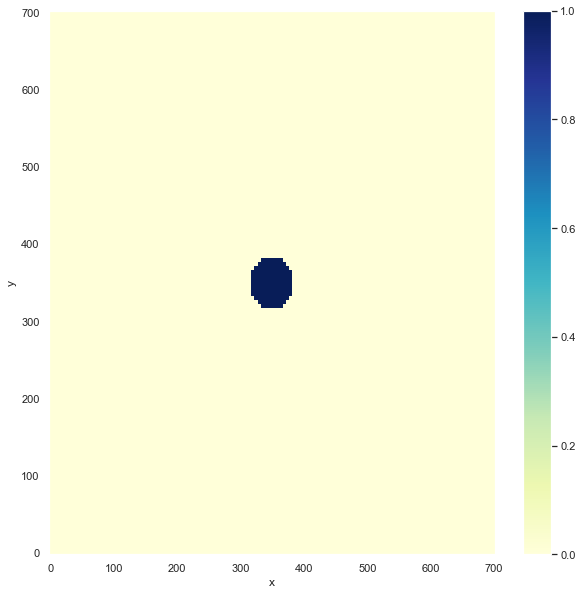

In [4]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\02_esfera_metalica_7mm_350_350_10mm\01_merged_files\C_Scan_time_raw.h5", 'x')

qx, qy, qt = c_scan.shape
X_train_2 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((y.size, x.size))

cx = 350
cy = 350
r = 35

mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
mine_map[mask] = 1

y_train_2 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)


### Escenario 3

Altura antena: 60 cm.
Campo: 70 x 70 cm.
Altura arena: 26 cm.

Esfera metálica de 7 cm  de diámetro enterrada a 11 cm de profundidad, cuyo centro se encuentra en las coordenadas X-Y (35 cm , 35 cm).

x: (0.0, 0.7)
y: (0.0, 0.7)


C:\Users\leone\AppData\Local\Temp/ipykernel_4812/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


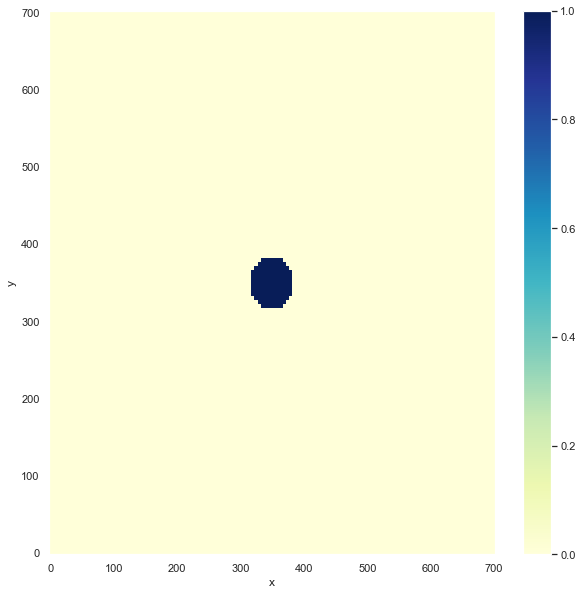

In [5]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\03_esfera_metalica_7mm_350_350_110mm\01_merged_files\C_Scan_time_raw.h5", 'x')

qx, qy, qt = c_scan.shape
X_train_3 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((y.size, x.size))

cx = 350
cy = 350
r = 35

mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
mine_map[mask] = 1

y_train_3 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 5

Altura antena: 42 cm.
Campo: 70 x 70 cm.
Altura arena: 26 cm.

Mina de plástico enterrada a 2 cm de profundidad. Geometría cilíndrica vertical con centro en (35, 35) y 7 cm de diámetro.

x: (0.0, 0.7)
y: (0.0, 0.7)


C:\Users\leone\AppData\Local\Temp/ipykernel_4812/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


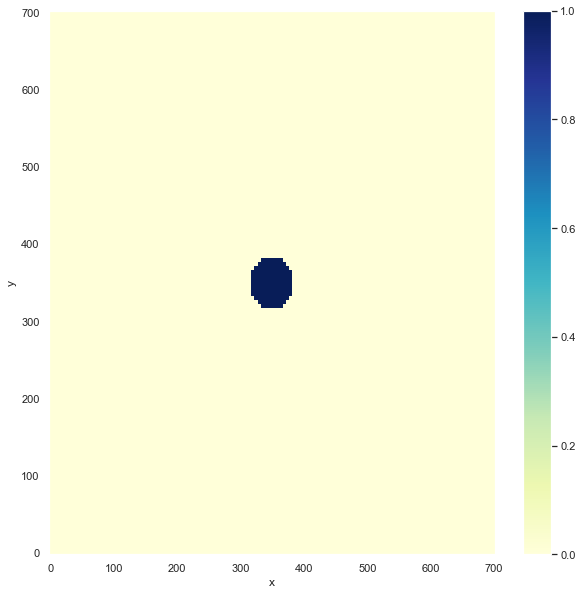

In [6]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\05_mina_350_350\02_merged_files\C_Scan_time_raw.h5", 'x')

qx, qy, qt = c_scan.shape
X_train_5 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((y.size, x.size))

cx = 350
cy = 350
r = 35

mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
mine_map[mask] = 1

y_train_5 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 6

Altura antena: 60 cm.
Campo: 70 x 70 cm.
Altura arena: 26 cm.

Placa metálica de 25 cm de lado enterrada a 2 cm de profundidad, cuyo centro se encuentra en las coordenadas X-Y (35 cm , 35 cm).


x: (0.0, 0.7)
y: (1.0, 1.7)


C:\Users\leone\AppData\Local\Temp/ipykernel_4812/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


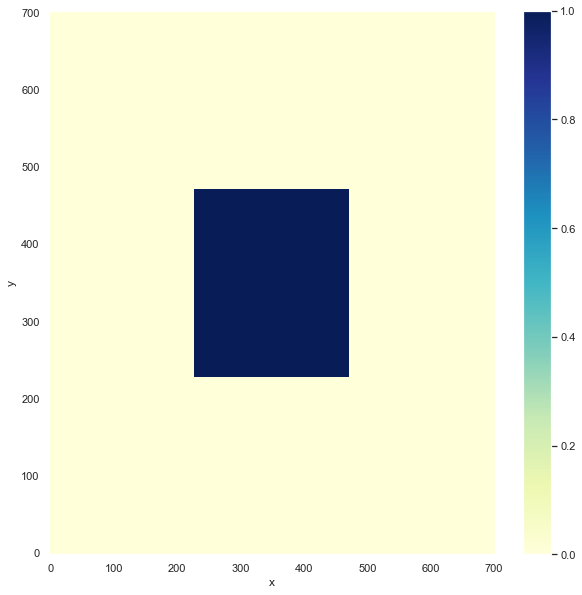

In [7]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\06_placa_metalica_350_1350\02_merged_files\C_Scan_time_raw.h5", 'x')

qx, qy, qt = c_scan.shape
X_train_6 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((y.size, x.size))

cx = 350
cy = 350
l = 250

mask_x= np.abs(x-cx) < l/2.
mask_y= np.abs(y-cy) < l/2

mine_map[np.ix_(np.flatnonzero(mask_y), np.flatnonzero(mask_x))] = 1

y_train_6 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

## Unión de escenarios


In [8]:
X_train = np.concatenate((X_train_2, X_train_3, X_train_5, X_train_6), axis=0)
y_train = np.concatenate((y_train_2, y_train_3, y_train_5, y_train_6), axis=0)

In [14]:
X_train.shape

(79524, 555)

In [9]:
dict_learner = DictionaryLearning(n_components=600, fit_algorithm='cd', transform_algorithm='omp', verbose=True)
X_sparse = dic  t_learner.fit_transform(X_train)


[dict_learning] .600 unused atoms resampled.
.600 unused atoms resampled.



C:\Users\leone\anaconda3\envs\env\lib\site-packages\sklearn\decomposition\_dict_learning.py:207: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [29]:
joblib.dump(dict_learner, 'dict2.joblib')

['dict2.joblib']

In [39]:
svc = SVC(probability = True)

param_grid = {
    'C': np.logspace(-3, 3, num = 7),
    'gamma': np.logspace(-3, 3, num = 7)
}

best_model = GridSearchCV(svc, param_grid, cv= 3, scoring = 'recall', verbose = 3)
best_model.fit(X_sparse, y_train)
best_model.score(X_sparse, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ..............C=0.001, gamma=0.001;, score=0.000 total time= 1.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ..............C=0.001, gamma=0.001;, score=0.000 total time= 1.2min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ..............C=0.001, gamma=0.001;, score=0.000 total time= 1.1min
SKLEARNEX INFO: sklearn.svm.SVC.fit

C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END .................C=0.1, gamma=10.0;, score=0.000 total time=15.7min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END .................C=0.1, gamma=10.0;, score=0.000 total time=15.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ................C=0.1, gamma=100.0;, score=0.000 total time=10.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ................C=0.1, gamma=100.0;, score=0.000 total time=10.8min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ................C=0.1, gamma=100.0;, score=0.000 total time=13.1min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ...............C=0.1, gamma=1000.0;, score=0.000 total time=10.1min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ...............C=0.1, gamma=1000.0;, score=0.000 total time=10.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ...............C=0.1, gamma=1000.0;, score=0.000 total time=10.9min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.s

C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END .................C=1.0, gamma=10.0;, score=0.002 total time=20.1min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END .................C=1.0, gamma=10.0;, score=0.000 total time=20.2min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ................C=1.0, gamma=100.0;, score=0.000 total time=22.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ................C=1.0, gamma=100.0;, score=0.000 total time=22.7min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ................C=1.0, gamma=100.0;, score=0.000 total time=17.8min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ...............C=1.0, gamma=1000.0;, score=0.000 total time=17.4min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ...............C=1.0, gamma=1000.0;, score=0.000 total time=17.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ...............C=1.0, gamma=1000.0;, score=0.000 total time=16.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ...............C=10.0, gamma=0.001;, score=0.035 total time= 1.3min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.s

C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ................C=10.0, gamma=10.0;, score=0.003 total time=22.4min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ................C=10.0, gamma=10.0;, score=0.000 total time=21.4min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ...............C=10.0, gamma=100.0;, score=0.000 total time=10.7min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ...............C=10.0, gamma=100.0;, score=0.000 total time=11.1min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ...............C=10.0, gamma=100.0;, score=0.000 total time= 8.8min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ..............C=10.0, gamma=1000.0;, score=0.000 total time=10.4min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.s

C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 1/3] END ...............C=100.0, gamma=10.0;, score=0.004 total time=32.6min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ...............C=100.0, gamma=10.0;, score=0.003 total time=32.1min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ...............C=100.0, gamma=10.0;, score=0.000 total time=30.5min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.s

C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 2/3] END ..............C=100.0, gamma=100.0;, score=0.000 total time=13.7min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END ..............C=100.0, gamma=100.0;, score=0.000 total time=11.2min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
[CV 1/3] END ...............C=100.0, gamma=1000.0;, score=nan total time= 6.8min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
[CV 2/3] END ...............C=100.0, gamma=1000.0;, score=nan total time= 8.7min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU
[CV 3/3] END .............C=100.0, gamma=1000.0;, score=0.000 total time=10.4min
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
[CV 1/3] END ...............C=1000.0, gamma=0.001;, score=nan total time=  25.9s
SKLEARNEX I

C:\Users\leone\anaconda3\envs\env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 147.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py", line 436, in _process_worker
    r = call_item()
  File "C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\leone\anaconda3\envs\env\lib\site-packages\joblib\_parallel_backend

MemoryError: bad allocation

In [16]:
best_model = SVC(C = 1000, gamma = 0.01, probability = True)
best_model.fit(X_sparse, y_train)

SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.fit: running accelerated version on CPU


SVC(C=1000, gamma=0.01, probability=True)

In [17]:
best_model.score(X_sparse, y_train)

SKLEARNEX INFO: sklearn.svm.SVC.predict: running accelerated version on CPU


0.9991826366882953

In [43]:
best_model.best_params_

{'C': 1000.0, 'gamma': 0.01}

In [42]:
best_model.best_score_

0.5327717932369095

In [28]:
joblib.dump(best_model, 'svcC1000g001.joblib')

['svcC1000g001.joblib']

## Evaluación

### Escenario 1

Campo: 70 cm x 70 cm

Sin objetos

x: (0.0, 0.7)
y: (0.0, 0.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


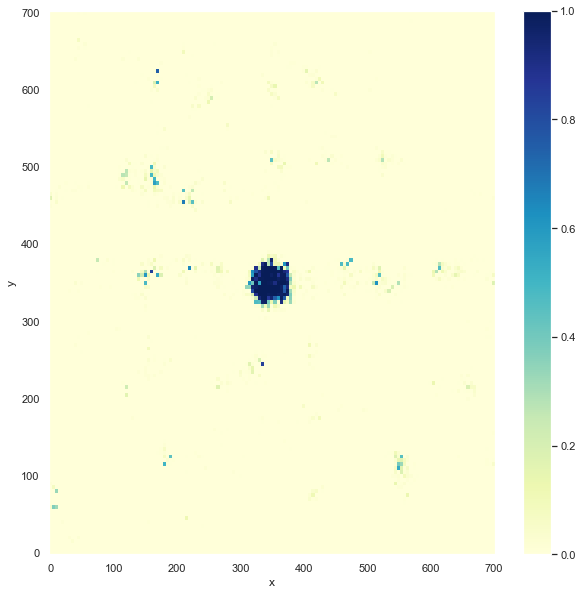

In [20]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\01_solo_arena\01_merged_files\C_Scan_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

## Escenario 2: Entrenamiento

x: (0.0, 0.7)
y: (0.0, 0.7)


C:\Users\leone\anaconda3\envs\env\lib\site-packages\sklearn\decomposition\_dict_learning.py:207: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


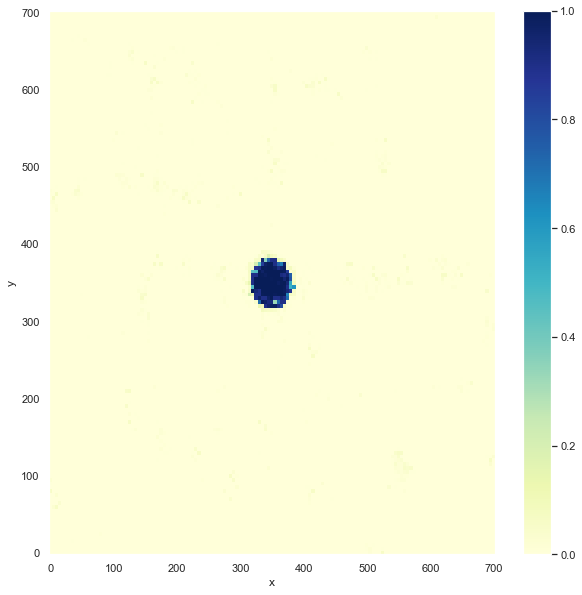

In [19]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\02_esfera_metalica_7mm_350_350_10mm\01_merged_files\C_Scan_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

## Escenario 3: Entrenamiento

x: (0.0, 0.7)
y: (0.0, 0.7)


C:\Users\leone\anaconda3\envs\env\lib\site-packages\sklearn\decomposition\_dict_learning.py:207: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


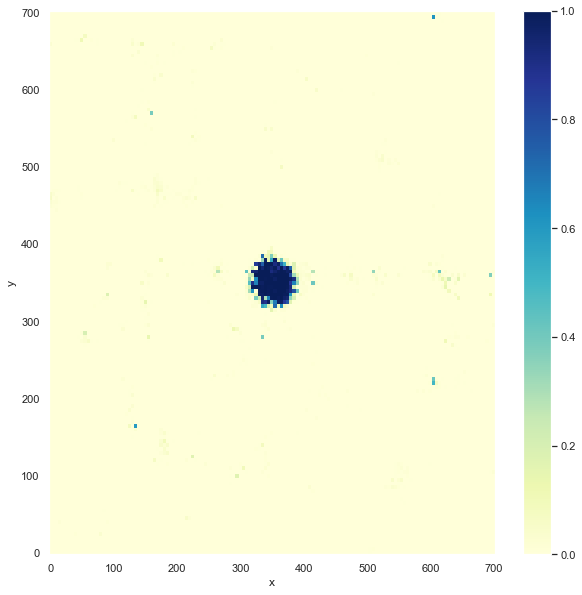

In [21]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\03_esfera_metalica_7mm_350_350_110mm\02_merged_files\C_Scan_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

## Escenario 4

Solo arena



x: (0.0, 0.7)
y: (1.0, 1.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


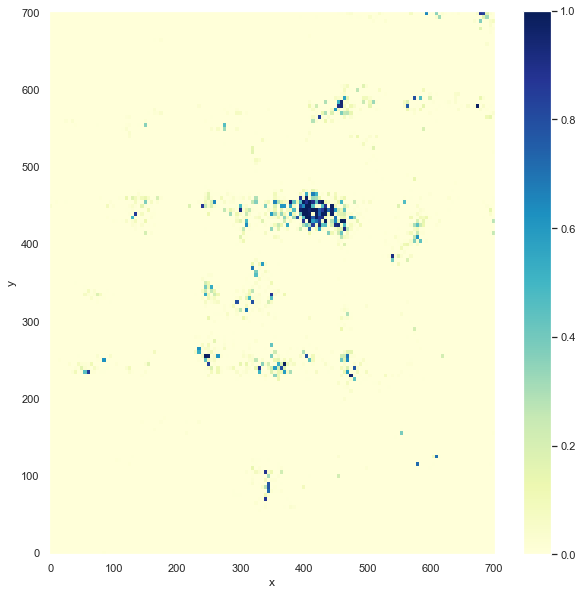

In [22]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\04_solo_arena_1000_1700\02_merged_files\C_Scan_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

## Escenario 11


x: (0.0, 0.7)
y: (0.0, 0.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_16872/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


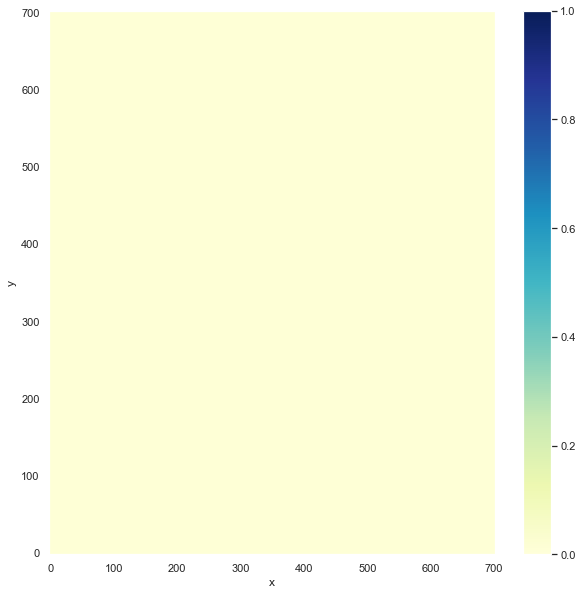

In [38]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\11_arena_alta_mina\02_merged_files\C_Scan_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 7

Campo: 70 cm x 70 cm

Objetos:
- Mina
- Esfera

x: (0.0, 0.7)
y: (0.0, 0.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


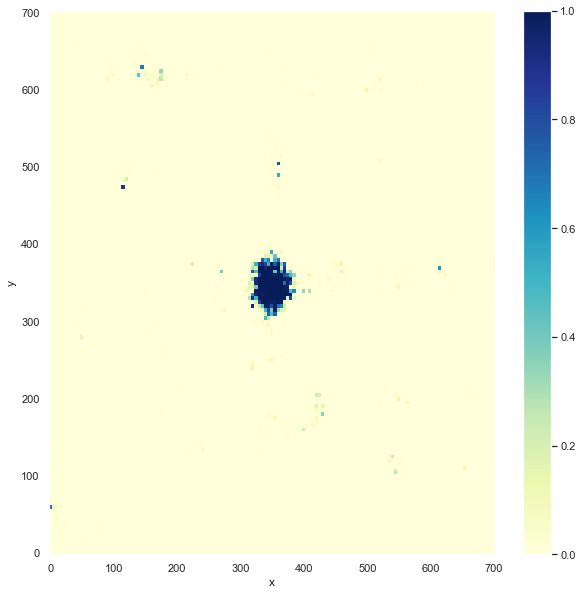

In [23]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\07_mina_350_350_esfera_450_250\02_merged_files\C_Scan_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 8

x: (0.0, 0.7)
y: (1.0, 1.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


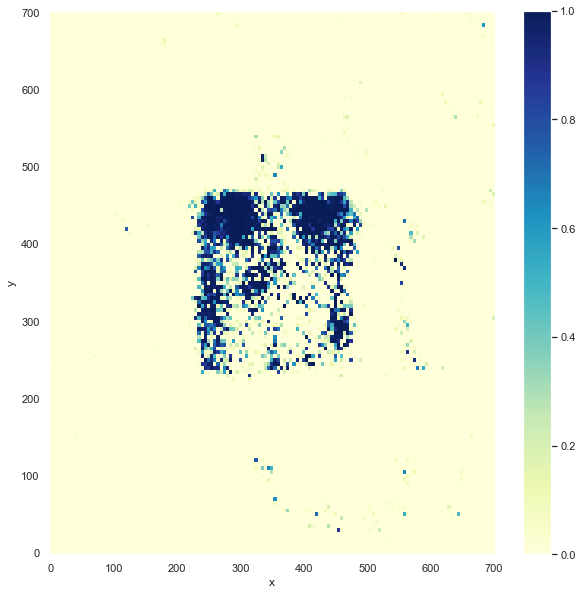

In [24]:
c_scan = read_c_scan(r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\08_placa_350_1350_esfera_200_1500\02_merged_files\C_Scan_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

## Mediciones Gabriel

### Escenario 1

x: (0.0, 0.7)
y: (1.0, 1.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


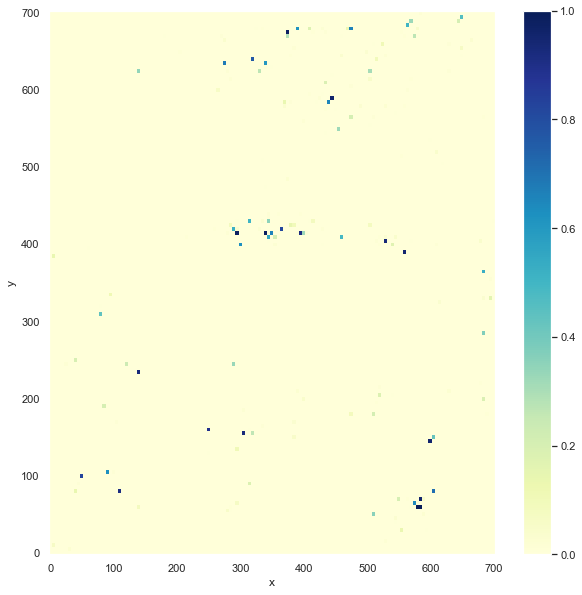

In [25]:
c_scan = read_c_scan(r"C:\Users\leone\OneDrive - Universidad de los Andes\Universidad\Proyecto Desminado\Mediciones Gabriel\01.2_solo_arena\202112161844\Time\C_Scans\C_scan_default_title.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

x: (0.0, 0.7)
y: (0.0, 0.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


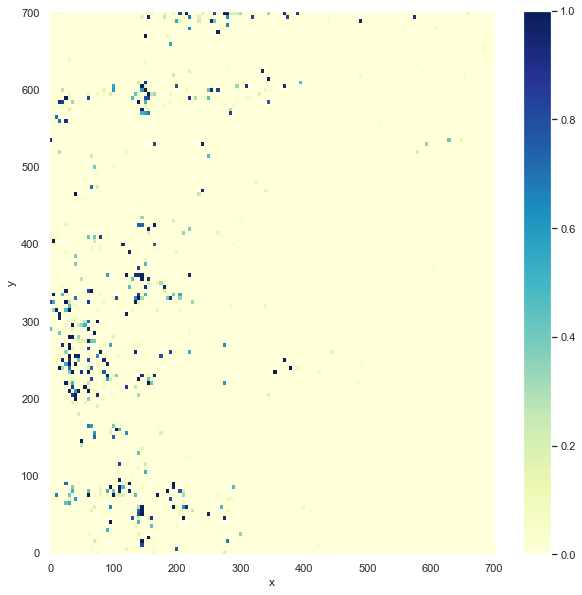

In [26]:
c_scan = read_c_scan(r"C:\Users\leone\OneDrive - Universidad de los Andes\Universidad\Proyecto Desminado\Mediciones Gabriel\02.2_esfera_metalica_7mm_350_350_10mm\merged_files\C_scan_02.2_esfera_metalica_7mm_350_350_10mm_time_raw.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)

x: (0.0, 0.7)
y: (0.0, 0.7)
SKLEARNEX INFO: sklearn.svm.SVC.predict_proba: running accelerated version on CPU
SKLEARNEX INFO: sklearn.svm.SVC.decision_function: running accelerated version on CPU


C:\Users\leone\AppData\Local\Temp/ipykernel_1952/4152128146.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


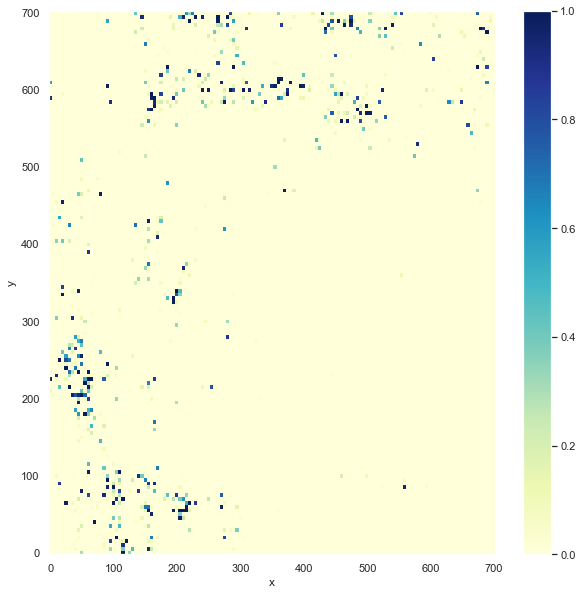

In [27]:
c_scan = read_c_scan(r"C:\Users\leone\OneDrive - Universidad de los Andes\Universidad\Proyecto Desminado\Mediciones Gabriel\03.2_esfera_metalica_7mm_350_350_110mm\202112161017\Time\C_Scans\C_scan_default_title.h5", 'x')
qx, qy, qt = c_scan.shape
X_test = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_pred = best_model.predict_proba(dict_learner.transform(X_test))
mine_pred = np.reshape(mine_pred[:,1], (qx, qy))
plot_mine_map(x, y, mine_pred)